In [4]:
from trackml.dataset import load_event
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

path = '/nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/'
event = 'event000001000'

print('Loading event {}'.format(path+event))

hits, cells, particles, truth = load_event(path+event)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event, mem_bytes / 2**20))

Loading event /nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/event000001000
event000001000 memory usage 18.46 MB


   hit_id          x         y       z  volume_id  layer_id  module_id
0       1 -64.409897 -7.163700 -1502.5          7         2          1
1       2 -55.336102  0.635342 -1502.5          7         2          1
2       3 -83.830498 -1.143010 -1502.5          7         2          1
3       4 -96.109100 -8.241030 -1502.5          7         2          1
4       5 -62.673599 -9.371200 -1502.5          7         2          1


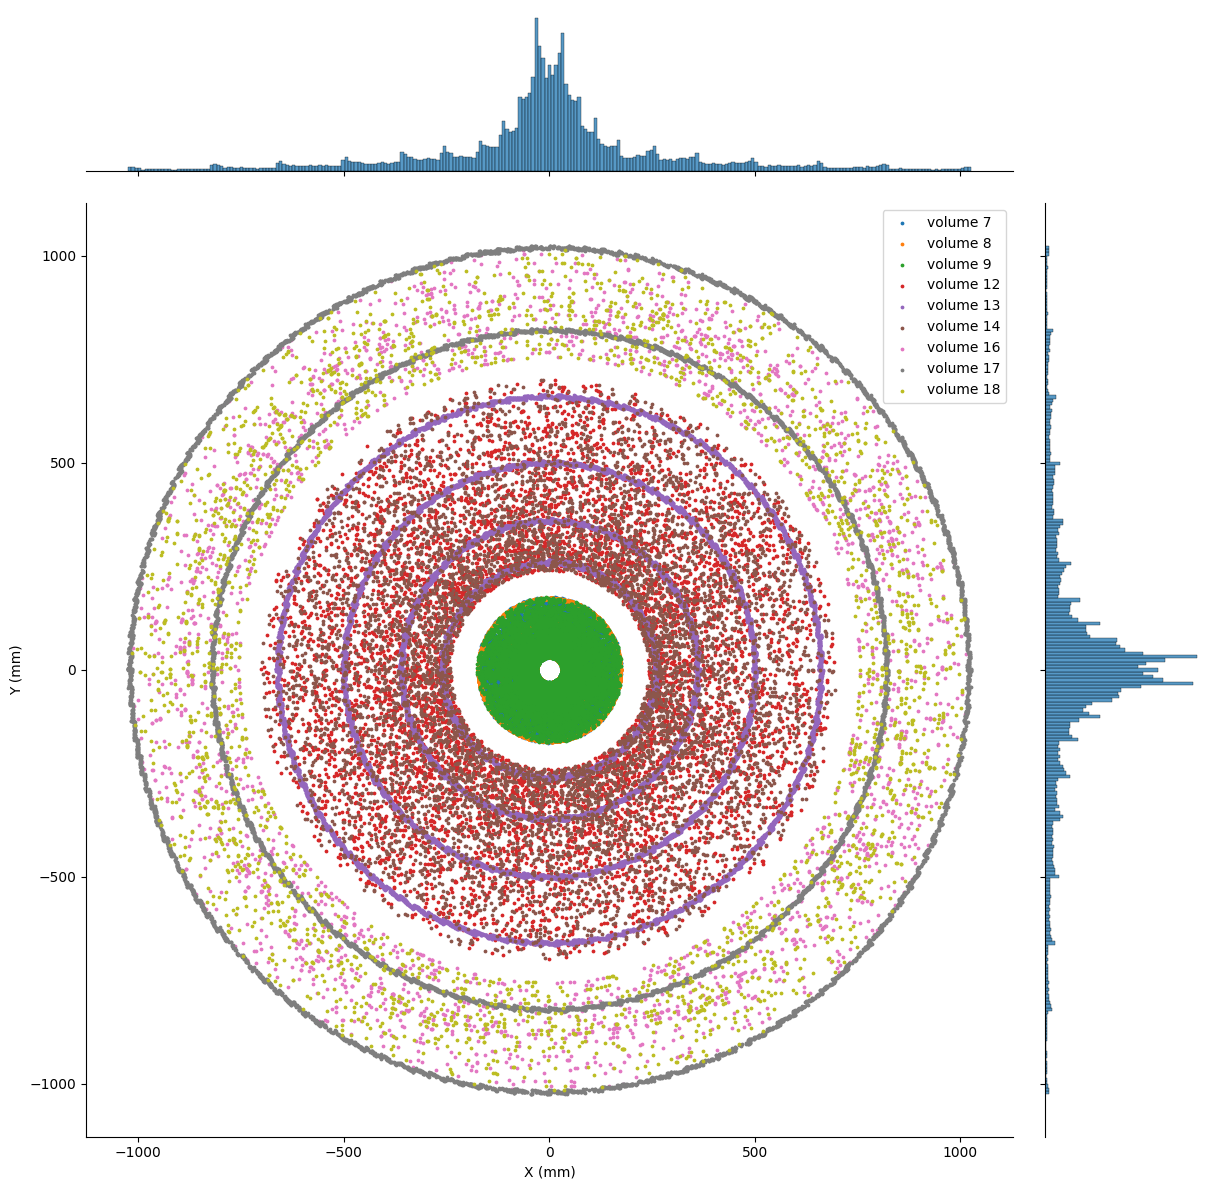

In [5]:
'''
Representación de los hits
'''
print(hits.head())

g = sns.jointplot(x=hits.x, y=hits.y, s=1, height=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

In [19]:
import importlib
import kalman_filter
importlib.reload(kalman_filter)
from kalman_filter import KalmanFilter
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt

#print(hits.head())
print("Dimensión dataset hits:  ", hits.shape)
'''
Voy a querer elegir primero solo los hits centrales, es decir, los del volumen 8
'''

print("=========== Hits centrales ===========")
hits_centrales = hits[hits.volume_id == 8]
print(hits_centrales.head())
print(hits_centrales.shape)

print("Tomamos solo un {:.4f}% de los hits".format(hits_centrales.shape[0]/hits.shape[0]*100))

data = hits_centrales[['x', 'y', 'z']].values
print(data)
print(data.shape)


plt.plot(data[:,0], 'o', label='X', markersize=.3)
plt.xlabel('Hit')
plt.ylabel('X (mm)')
plt.show()

'''
Tengo que calcular x0 como trayectoria inicial entre un par de hits. 
'''

x0 = np.array([data[0,0], 0, data[0,1], 0, data[0,2], 0])

dim_data = data.shape[1]

dt = 1.0
F = np.array([[1, dt, 0,  0,  0,  0],
              [0,  1,  0,  0,  0,  0],
              [0,  0,  1, dt,  0,  0],
              [0,  0,  0,  1,  0,  0],
              [0,  0,  0,  0,  1, dt],
              [0,  0,  0,  0,  0,  1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0]])

C = np.eye(6) * 1e3
Q = np.eye(6) * 0.1
R = np.eye(3) * 0.3

kf = KalmanFilter(C = C, F = F, 
                  H = H, Q = Q, R = R, x0 = x0)

trajectory = []
for i in range(len(data)):
    m = data[i]
    kf.predict()
    kf.update(m)
    trajectory.append(kf.x[[0, 2, 4]].flatten())

# Convertir a DataFrame
print("\n=========== Filtered_df ===========")
filtered_df = pd.DataFrame(trajectory, columns=["x", "y", "z"])
print(filtered_df)

trajectory = np.array(trajectory)

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Kalman Filter')

ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:,0], data[:,1], data[:,2], 'o', label='Data', markersize=1)
ax.scatter(trajectory[:,0], trajectory[:,1], trajectory[:,2], label='Filtered', color='red')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
plt.legend()
plt.show()





Dimensión dataset hits:   (120939, 7)
=========== Hits centrales ===========
       hit_id          x          y           z  volume_id  layer_id  \
16873   16874 -32.554401  -3.648710 -469.864990          8         2   
16874   16875 -33.153702  -1.934740 -423.516998          8         2   
16875   16876 -26.362400 -18.423700 -461.375000          8         2   
16876   16877 -12.034100 -29.649799 -464.428009          8         2   
16877   16878 -15.127200 -28.159300 -439.713989          8         2   

       module_id  
16873          1  
16874          1  
16875          2  
16876          3  
16877          3  
(29172, 7)
Tomamos solo un 24.1213% de los hits
[[ -32.5544    -3.64871 -469.865  ]
 [ -33.1537    -1.93474 -423.517  ]
 [ -26.3624   -18.4237  -461.375  ]
 ...
 [-171.905      9.853    438.322  ]
 [-172.016     10.9689   472.256  ]
 [-171.024      1.0491   427.278  ]]
(29172, 3)
Dimensión de m: (3, 1)
Dimensión de r: (3, 1)
Dimensión de K: (6, 3)
Dimensión de self.x antes 

In [7]:
'''
# Lista para almacenar las estimaciones de posición y velocidad
estimaciones = []

# Iterar sobre el dataset
for index, row in particles.iterrows():
    m = np.array([[row['vx']], [row['vy']], [row['vz']], [row['px']], [row['py']], [row['pz']]])  
    kf.predict()
    estimacion = kf.update(m)  # Paso de actualización con la medición actual
    estimaciones.append(estimacion.flatten())


# Convertir las estimaciones en un DataFrame para analizar
estimaciones_df = pd.DataFrame(estimaciones, columns=['vx_est', 'vy_est', 'vz_est', 'px_est', 'py_est', 'pz_est'])

# Mostrar las estimaciones
print("===============Estimaciones===============")
#print(estimaciones_df.head())

particles["vx_estimada"] = estimaciones_df["vx_est"]
particles["vy_estimada"] = estimaciones_df["vy_est"]
particles["vz_estimada"] = estimaciones_df["vz_est"]
particles["px_estimada"] = estimaciones_df["px_est"]
particles["py_estimada"] = estimaciones_df["py_est"]
particles["pz_estimada"] = estimaciones_df["pz_est"]

#print(particles)
print(particles.shape)

print(particles["vx"])
print(particles["vx_estimada"])


#print("===============Errores===============")
# Calcular los errores
particles["vx_error"] = particles["vx"] - particles["vx_estimada"]
particles["vy_error"] = particles["vy"] - particles["vy_estimada"]
particles["vz_error"] = particles["vz"] - particles["vz_estimada"]
particles["px_error"] = particles["px"] - particles["px_estimada"]
particles["py_error"] = particles["py"] - particles["py_estimada"]
particles["pz_error"] = particles["pz"] - particles["pz_estimada"]

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(particles["vx"], '-')
plt.xlabel('Event number')
plt.ylabel('X (mm)')
plt.title('Vertex X coordinate')

plt.subplot(1,2,2)
plt.plot(particles["vx_estimada"], '-', color='maroon')
plt.xlabel('Event number')
plt.ylabel('X (mm)')
plt.title('Vertex X coordinate')


plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(particles['vx_error'], label='Error X', linestyle='-')
plt.xlabel('Número de Evento')
plt.ylabel('Error X (mm)')
plt.title('Error en la posición X')
plt.legend()

plt.show()'
'''



'\n# Lista para almacenar las estimaciones de posición y velocidad\nestimaciones = []\n\n# Iterar sobre el dataset\nfor index, row in particles.iterrows():\n    m = np.array([[row[\'vx\']], [row[\'vy\']], [row[\'vz\']], [row[\'px\']], [row[\'py\']], [row[\'pz\']]])  \n    kf.predict()\n    estimacion = kf.update(m)  # Paso de actualización con la medición actual\n    estimaciones.append(estimacion.flatten())\n\n\n# Convertir las estimaciones en un DataFrame para analizar\nestimaciones_df = pd.DataFrame(estimaciones, columns=[\'vx_est\', \'vy_est\', \'vz_est\', \'px_est\', \'py_est\', \'pz_est\'])\n\n# Mostrar las estimaciones\nprint("===============Estimaciones===============")\n#print(estimaciones_df.head())\n\nparticles["vx_estimada"] = estimaciones_df["vx_est"]\nparticles["vy_estimada"] = estimaciones_df["vy_est"]\nparticles["vz_estimada"] = estimaciones_df["vz_est"]\nparticles["px_estimada"] = estimaciones_df["px_est"]\nparticles["py_estimada"] = estimaciones_df["py_est"]\nparticle